<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Acquire-the-data" data-toc-modified-id="Acquire-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Acquire the data</a></span></li><li><span><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore the data</a></span><ul class="toc-item"><li><span><a href="#Investigate-target-variable" data-toc-modified-id="Investigate-target-variable-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Investigate target variable</a></span></li><li><span><a href="#Investigate-Numeric-Features" data-toc-modified-id="Investigate-Numeric-Features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Investigate Numeric Features</a></span></li><li><span><a href="#Investigate-non-numeric-Features" data-toc-modified-id="Investigate-non-numeric-Features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Investigate non-numeric Features</a></span></li></ul></li><li><span><a href="#Transforming-and-engineering-features" data-toc-modified-id="Transforming-and-engineering-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transforming and engineering features</a></span><ul class="toc-item"><li><span><a href="#One-hot-encoding-of-categorical-variables" data-toc-modified-id="One-hot-encoding-of-categorical-variables-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>One-hot encoding of categorical variables</a></span></li><li><span><a href="#Deal-with-null-values" data-toc-modified-id="Deal-with-null-values-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Deal with null values</a></span></li></ul></li><li><span><a href="#Build-Linear-Model" data-toc-modified-id="Build-Linear-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build Linear Model</a></span><ul class="toc-item"><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Evaluate model</a></span></li></ul></li><li><span><a href="#Make-a-submission" data-toc-modified-id="Make-a-submission-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Make a submission</a></span></li></ul></div>

# House Prices: Advanced Regression Techniques 

We’ll follow these steps to a successful Kaggle Competition submission:

- Acquire the data
- Explore the data
- Engineer and transform the features and the target variable
- Build a model
- Make and submit predictions

## Acquire the data

In [1]:
# Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
%matplotlib inline

We will first look at the `train.csv` data. After we’ve trained a model, we’ll make predictions using the `test.csv` data.

In [2]:
# Read in csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Check size of data
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


Test data does not include target column.

In [4]:
# Preview data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore the data

### Investigate target variable

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average sale price of a house in our dataset is close to USD 180 000 with most of the values falling within the USD 130,000 to USD 215,000 range.

Next, we’ll check for skewness, which is a measure of the shape of the distribution of values.

Skew is: 1.8828757597682129


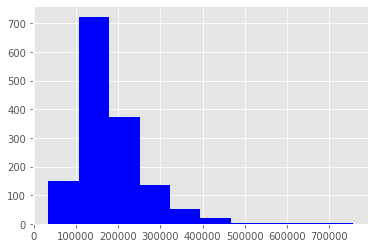

In [6]:
print ("Skew is:", train['SalePrice'].skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

Notice that the distribution has a longer tail on the right. The distribution is positively skewed.

Now we use `np.log()` to transform `SalePrice` and calculate the skewness a second time, as well as re-plot the data. A value closer to 0 means that we have improved the skewness of the data.

Skew is: 0.12133506220520406


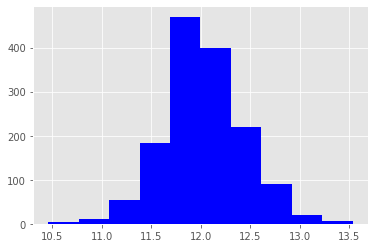

In [7]:
target = np.log(train['SalePrice'])
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

We can see visually that the data better resembles a normal distribution.

### Investigate Numeric Features

In [8]:
# get numeric features
numeric_features = train.select_dtypes(include=[np.number])

In [9]:
numeric_features.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


### Investigate non-numeric Features

In [10]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


The count column indicates the count of non-null observations, while unique counts the number of unique values. top is the most commonly occurring value, with the frequency of the top value shown by freq.

For many of these features, we might want to use one-hot encoding to make use of the information for modeling.

## Transforming and engineering features

### One-hot encoding of categorical variables

When transforming features, it’s important to remember that any transformations that you’ve applied to the training data before fitting the model must be applied to the test data.

Our model expects that the shape of the features from the train set match those from the test set. This means that any feature engineering that occurred while working on the train data should be applied again on the test set.

Consider the `Street` data, which indicates whether there is `Gravel` or `Paved` road access to the property.

In [11]:
train['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

Our model needs numerical data, so we will use one-hot encoding to transform the data into a Boolean column.

In [12]:
train['enc_street'] = pd.get_dummies(train['Street'], drop_first=True)
test['enc_street'] = pd.get_dummies(train['Street'], drop_first=True)

Let’s try engineering another feature. 

We’ll look at `SaleCondition` by constructing and plotting a pivot table

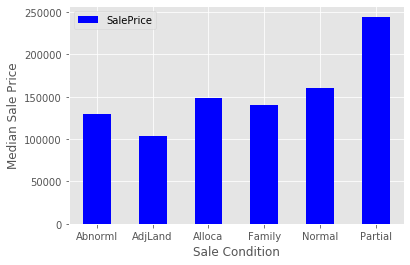

In [13]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

Notice that `Partial` has a significantly higher Median Sale Price than the others. We will encode this as a new feature. We select all of the houses where `SaleCondition` is equal to `Patrial` and assign the value `1`, otherwise assign `0`.

In [14]:
def encode(x):
    return 1 if x == 'Partial' else 0

train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

### Deal with null values

In [15]:
# Get number of Null Values in each column
train.isna().sum().sort_values(ascending = False)[:22]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
RoofStyle          0
ExterQual          0
dtype: int64

The documentation can help us understand the missing values. In the case of PoolQC, the column refers to Pool Quality. Pool quality is NaN when PoolArea is 0, or there is no pool.
We can find a similar relationship between many of the Garage-related columns

We’ll fill the missing values with an average value. This is a method of interpolation. The DataFrame.interpolate() method makes this simple.

This is a quick and simple method of dealing with missing values, and might not lead to the best performance of the model on new data. Handling missing values is an important part of the modeling process, where creativity and insight can make a big difference. 

In [16]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [17]:
# check
data.isna().any().any()

False

## Build Linear Model

In [18]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,enc_street,enc_condition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,2,2008,208500,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,5,2007,181500,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,9,2008,223500,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,272,0,0,0,0,2,2006,140000,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,12,2008,250000,1,0


In [19]:
y = np.log(train['SalePrice'])
X = data.drop(['Id', 'SalePrice'], axis = 1)

In [20]:
# Train-test-split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [21]:
# Create Linear Regression model
from sklearn import linear_model
linreg = linear_model.LinearRegression()

Next, we need to fit the model using X_train and y_train. The `lr.fit()` method will fit the linear regression on the features and target variable that we pass.

In [22]:
# Fit the model
model = linreg.fit(X_train, y_train)

### Evaluate model

Kaggle will evaluate our submission using root-mean-squared-error (RMSE). We’ll also look at The r-squared value. The r-squared value is a measure of how close the data are to the fitted regression line. It takes a value between 0 and 1, 1 meaning that all of the variance in the target is explained by the data. In general, a higher r-squared value means a better fit.

The `model.score()` method returns the r-squared value by default.

In [23]:
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.8647463410578131


This means that our features explain approximately 86% of the variance in our target variable.

Next, we’ll consider RMSE. To do so, use the model we have built to make predictions on the test data set.

In [24]:
y_hat_test = model.predict(X_test)

The `model.predict()` method will return a list of predictions given a set of predictors. Use model.predict() after fitting the model.

In [25]:
y_hat_test[:5]

array([11.9279834 , 12.613182  , 11.68259543, 12.05987131, 12.63253959])

In [26]:
y_test[:5]

892     11.947949
1105    12.691580
413     11.652687
522     11.976659
1036    12.661914
Name: SalePrice, dtype: float64

In [27]:
test_residuals = y_hat_test - y_test

The `mean_squared_error` function takes two arrays and calculates the rmse.

In [37]:
mean_squared_error(y_hat_test, y_test)

0.023051468191914493

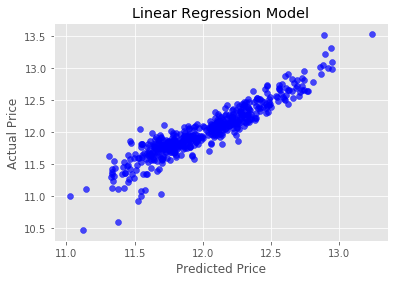

In [29]:
# Plot
actual_values = y_test
plt.scatter(y_hat_test, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

## Make a submission

We’ll need to create a `csv` that contains the predicted `SalePrice` for each observation in the `test.csv` dataset.

The first column must the contain the ID from the test data.

In [30]:
submission = pd.DataFrame()
submission['Id'] = test['Id']

Now, select the features from the test data for the model as we did above.


In [31]:
# Select numeric features and drop ID, interpolate for missing values
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

In [32]:
# Generate predictions
predictions = model.predict(feats)

Now we’ll transform the predictions to the correct form. Remember that to reverse `log()` we do `exp()`.
So we will apply `np.exp()` to our predictions becasuse we have taken the logarithm previously.

In [33]:
# Taxe exponential to reverse log
final_predictions = np.exp(predictions)

In [34]:
# Define SalePrice in our submission DataFrame
submission['SalePrice'] = final_predictions

In [35]:
# Final check
submission.head()

,Id,SalePrice
0,1461,119200.553747
1,1462,122833.458451
2,1463,168109.565842
3,1464,195206.400915
4,1465,181094.634857


One we’re confident that we’ve got the data arranged in the proper format, we can export to a `.csv` file as Kaggle expects. We pass `index=False` because Pandas otherwise would create a new index for us.

In [36]:
submission.to_csv('submission1.csv', index=False)

We’ve created a file called `submission1.csv` in our working directory that conforms to the correct format. Let's submit!